In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
google_countries = pd.read_csv('../raw_data/google_data/mobility_report_countries.csv')
jhu_confirmed = pd.read_csv('../raw_data/csse_data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
jhu_deaths = pd.read_csv('../raw_data/csse_data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

remove_transit_nans = True # either drop all of the information or we will account for them later



In [3]:
if remove_transit_nans: # for incomplete data, there will be a check that we have all of the days
    google_countries = google_countries[google_countries['transit stations'].notna()]

In [4]:
jhu_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,521,555,607,665,714,784,840,906,933,996
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,416,433,446,467,475,494,518,539,548,562
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,601,601,638,646,659,673,673,696,704,713
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,19,19,19,24,24


In [5]:
# the jhu data does not have it on a micro scale like google, let's find all of the pairs that JHU has 
# jhu countries deaths = confirmed 
provinces = jhu_confirmed['Province/State'].unique()
countries = jhu_confirmed['Country/Region'].unique()
province_country_pairs = [['Total','Afghanistan']] # base
for i in range(len(jhu_confirmed)):
    pair = list(jhu_confirmed.iloc[i].values[0:2])
    
    # replacing the nan with 'total', bad code but don't worry, no real values are len 3
    if len(str(pair[0])) == 3:  
        pair[0] = 'Total'
    if pair in province_country_pairs:
        continue
    else:
        #adding in a unique
        province_country_pairs.append(pair)


In [6]:
# insert the first col back into the deaths and confirmed data
jhu_confirmed['Province/State']=np.array(province_country_pairs)[:,0]
jhu_deaths['Province/State']=np.array(province_country_pairs)[:,0]
jhu_deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,Total,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,15,18,18,21,23,25,30,30,30,33
1,Total,Albania,41.1533,20.1683,0,0,0,0,0,0,...,23,23,23,23,24,25,26,26,26,26
2,Total,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,256,275,293,313,326,336,348,364,367,375
3,Total,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,26,26,29,29,31,33,33,35,35,36
4,Total,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [7]:
google_countries.head()

,country,region,date,retail,grocery and pharmacy,parks,transit stations,workplaces,residential
0,United Arab Emirates,Total,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,United Arab Emirates,Total,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,United Arab Emirates,Total,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,United Arab Emirates,Total,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,United Arab Emirates,Total,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [8]:
master_df = pd.DataFrame(columns = google_countries.columns)

pairs_in_google = [['f','f']]
for pair in tqdm_notebook(province_country_pairs): 
    province = pair[0]
    country = pair[1]
    country_df = google_countries[(google_countries['region'] == province)\
                                      & (google_countries['country'] == country)].reset_index()
    if len(country_df) == 57:
        pairs_in_google.append(pair)
        master_df = master_df.append(country_df, ignore_index=True)
pairs_in_google.pop(0) #remove the [f,f] place holder

/Users/thomastran/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


['f', 'f']

In [11]:
assert(len(pairs_in_google) == len(master_df)/57)
print(len(pairs_in_google))

132


In [12]:
confirmed_list = [] 
deaths_list = [] 
for pair in tqdm_notebook(pairs_in_google): 
    province = pair[0]
    country = pair[1]
    # in the jhu data, find the confirmed and deaths for each pair 
    
    confirmed_list.extend(jhu_confirmed[(jhu_confirmed['Country/Region'] == country)\
                                      & (jhu_confirmed['Province/State'] == province)].T.iloc[28:85].values.T[0])
    deaths_list.extend(jhu_deaths[(jhu_deaths['Country/Region'] == country)\
                                      & (jhu_deaths['Province/State'] == province)].T.iloc[28:85].values.T[0])
master_df['cases'] = np.array(confirmed_list)
master_df['deaths'] = np.array(deaths_list)

In [15]:
master_df.to_csv('../processed_data/google_data/master_df_countries.csv')

In [91]:
# match the data using the intersection 
google_df = google_us[google_us.county.isin(intersect)]
nytimes_df = nytimes[nytimes.county.isin(intersect)]
google_df

,state,county,date,retail,grocery and pharmacy,parks,transit stations,workplaces,residential
114,Alabama,Autauga County,2020-02-15,5.0,7.0,NaN,NaN,-4.0,NaN
115,Alabama,Autauga County,2020-02-16,0.0,1.0,-23.0,NaN,-4.0,NaN
116,Alabama,Autauga County,2020-02-17,8.0,0.0,NaN,NaN,-27.0,5.0
117,Alabama,Autauga County,2020-02-18,-2.0,0.0,NaN,NaN,2.0,0.0
118,Alabama,Autauga County,2020-02-19,-2.0,0.0,NaN,NaN,2.0,0.0
...,...,...,...,...,...,...,...,...,...
155013,Wyoming,Washakie County,2020-04-06,NaN,NaN,NaN,NaN,-27.0,NaN
155014,Wyoming,Washakie County,2020-04-07,NaN,NaN,NaN,NaN,-29.0,NaN
155015,Wyoming,Washakie County,2020-04-08,NaN,NaN,NaN,NaN,-32.0,NaN
155016,Wyoming,Washakie County,2020-04-09,NaN,NaN,NaN,NaN,-32.0,NaN


In [95]:
master_df = pd.merge(left=google_df, right=nytimes_df, how='left',\
         left_on=['date','county','state'], right_on=['date','county','state'])

master_df.drop(columns = ['fips'], inplace = True)

# either drop if we don't care about data before
master_df.fillna(0, inplace = True)
master_df= master_df[master_df.date != '2020-04-11']

In [96]:
master_df.to_csv('master_df.csv')

[  0.  -3. -10.   3.   2.   1.  -1.  -7.   0.  -1.   2.   4.   3.   2.
   0.  -5.   0.   3.  -2.  -1.  -3.  -4.  -8.  -6. -15.  -7. -21. -23.
 -23. -26. -33. -30. -38. -45. -46. -45. -56. -52. -50. -51. -52. -52.
 -50. -55. -51. -49. -49. -52. -51. -50. -59. -63. -59. -55. -65. -58.
 -47.]


,state,county,date,retail,grocery and pharmacy,parks,transit stations,workplaces,residential,cases,deaths
9826,California,Orange County,2020-02-15,0.0,0.0,9.0,0.0,0.0,0.0,1.0,0.0
9827,California,Orange County,2020-02-16,4.0,-1.0,22.0,-3.0,0.0,-1.0,1.0,0.0
9828,California,Orange County,2020-02-17,10.0,1.0,34.0,-10.0,-33.0,6.0,1.0,0.0
9829,California,Orange County,2020-02-18,1.0,-2.0,7.0,3.0,2.0,0.0,1.0,0.0
9830,California,Orange County,2020-02-19,0.0,-2.0,8.0,2.0,2.0,0.0,1.0,0.0
9831,California,Orange County,2020-02-20,2.0,0.0,9.0,1.0,1.0,0.0,1.0,0.0
9832,California,Orange County,2020-02-21,1.0,-1.0,4.0,-1.0,1.0,0.0,1.0,0.0
9833,California,Orange County,2020-02-22,-2.0,-1.0,-23.0,-7.0,1.0,1.0,1.0,0.0
9834,California,Orange County,2020-02-23,5.0,-1.0,10.0,0.0,1.0,0.0,1.0,0.0
9835,California,Orange County,2020-02-24,1.0,-2.0,9.0,-1.0,4.0,-1.0,1.0,0.0


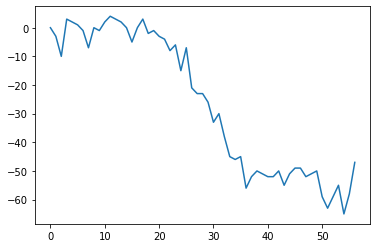

In [94]:

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm_notebook

def interpolate_data(transit_data):
    if np.count_nonzero(transit_data) <= 1: # absolutely no data or one data point 
        # print("no data to interpolate")
        a = np.empty(len(transit_data))
        a[:] = np.nan
        return a
    indice, = transit_data.nonzero()
    start, stop = indice[0], indice[-1]+1

    x = np.arange(len(transit_data))
    f = interp1d(x[indice], transit_data[indice])
    transit_data[start:stop] = f(x[start:stop])
    return transit_data

# example of selecting and interpolating data
butler_df = master_df[(master_df['county'] == "Orange County") & (master_df['state'] == "California")]
transit_data = np.array(butler_df['transit stations'])
print(transit_data)
plt.plot(np.arange(len(transit_data)), transit_data)
butler_df

In [97]:
interpolate_data(np.array([1.,2.,3.,4.,5.,4.]))

array([1., 2., 3., 4., 5., 4.])

In [98]:
print(len(county_state_pairs))
county_state_pairs

2608


[['Alabama', 'Autauga County'],
 ['Alabama', 'Baldwin County'],
 ['Alabama', 'Barbour County'],
 ['Alabama', 'Bibb County'],
 ['Alabama', 'Blount County'],
 ['Alabama', 'Bullock County'],
 ['Alabama', 'Butler County'],
 ['Alabama', 'Calhoun County'],
 ['Alabama', 'Chambers County'],
 ['Alabama', 'Cherokee County'],
 ['Alabama', 'Chilton County'],
 ['Alabama', 'Choctaw County'],
 ['Alabama', 'Clarke County'],
 ['Alabama', 'Clay County'],
 ['Alabama', 'Cleburne County'],
 ['Alabama', 'Coffee County'],
 ['Alabama', 'Colbert County'],
 ['Alabama', 'Conecuh County'],
 ['Alabama', 'Coosa County'],
 ['Alabama', 'Covington County'],
 ['Alabama', 'Crenshaw County'],
 ['Alabama', 'Cullman County'],
 ['Alabama', 'Dale County'],
 ['Alabama', 'Dallas County'],
 ['Alabama', 'DeKalb County'],
 ['Alabama', 'Elmore County'],
 ['Alabama', 'Escambia County'],
 ['Alabama', 'Etowah County'],
 ['Alabama', 'Fayette County'],
 ['Alabama', 'Franklin County'],
 ['Alabama', 'Geneva County'],
 ['Alabama', 'Greene

In [100]:
#iterate through all counties and states and iterpolate all of the data 
i = 0
for pair in tqdm_notebook(county_state_pairs): 
    state = pair[0]
    county = pair[1]
    transit_data = np.array(master_df['transit stations'][(master_df['county'] == county)\
                                  & (master_df['state'] == state)])
    if len(transit_data) < 56:
        print(len(transit_data))
        print(state, county)
        i+=1
    master_df['transit stations'][(master_df['county'] == county)\
                                  & (master_df['state'] == state)] = interpolate_data(transit_data)
print(i)

/Users/thomastran/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


40
Alabama Coosa County
51
Alabama Perry County
54
Alabama Pickens County
51
Alabama Sumter County
44
Alabama Wilcox County
47
Arkansas Chicot County
31
Arkansas Cleveland County
53
Arkansas Dallas County
40
Arkansas Fulton County
48
Arkansas Izard County
47
Arkansas Lincoln County
38
Arkansas Montgomery County
15
Arkansas Newton County
40
Arkansas Perry County
40
Arkansas Prairie County
50
Arkansas Scott County
33
Arkansas Searcy County
40
Colorado Gilpin County
0
Colorado Kiowa County
5
Colorado Ouray County
1
Colorado Phillips County
15
Colorado Rio Blanco County
22
Colorado Saguache County
49
Colorado San Miguel County
3
Colorado Washington County
36
Florida Lafayette County
41
Florida Liberty County
54
Georgia Atkinson County
21
Georgia Clinch County
42
Georgia Crawford County
47
Georgia Hancock County
47
Georgia Lanier County
40
Georgia Lincoln County
53
Georgia Marion County
28
Georgia Miller County
48
Georgia Montgomery County
51
Georgia Oglethorpe County
24
Georgia Randolph Co

53
Texas Crane County
14
Texas Crockett County
54
Texas Crosby County
12
Texas Delta County
9
Texas Donley County
9
Texas Floyd County
44
Texas Goliad County
46
Texas Hall County
51
Texas Haskell County
48
Texas Jack County
19
Texas Lynn County
52
Texas Newton County
55
Texas Sabine County
39
Texas San Augustine County
45
Texas Swisher County
1
Texas Wheeler County
51
Utah Emery County
5
Utah Garfield County
54
Utah Juab County
47
Utah Kane County
49
Utah Millard County
47
Utah Morgan County
51
Utah San Juan County
19
Vermont Essex County
40
Vermont Grand Isle County
4
Virginia Bath County
40
Virginia Charles City County
15
Virginia Craig County
41
Virginia Cumberland County
40
Virginia Grayson County
40
Virginia King and Queen County
48
Virginia Mathews County
19
Virginia Rappahannock County
40
Virginia Surry County
15
Washington Ferry County
40
Washington Lincoln County
41
West Virginia Grant County
40
West Virginia Lincoln County
40
West Virginia McDowell County
40
West Virginia Min

In [102]:
master_df = master_df[master_df['transit stations'].notna()]
master_df.to_csv("master_df_interpolated_data.csv",index = None)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    return line,


def animate(i):
    line.set_ydata(np.sin(x + i / 100))  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=2, blit=True, save_count=50)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# from matplotlib.animation import FFMpegWriter
# writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

In [ ]:
x